In [ ]:
#importing libraries
import pandas as pd
import math as mp
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
#for visualization of data
def visualize(df_basic,df_incremental,df_merge):
  # graph for basic code
  ax = df_basic.groupby(['CNumber'])['CNumber'].count().plot.bar(title = "Basic...")
  ax.set_xlabel('Clusters')
  ax.set_ylabel('Frequency')
  plt.show()

  #graph for incremental code
  ax = df_incremental.groupby(['CNumber'])['CNumber'].count().plot.bar(title = "Incremental")
  ax.set_xlabel('Clusters')
  ax.set_ylabel('Frequency')
  plt.show()

  #combined graph 
  ax = df_merge.groupby(['CNumber','Cluster_Type'])['Cluster_Type'].count().unstack(0).plot.bar(stacked=True, figsize=(16, 12))
  ax.legend(loc = 'center right',bbox_to_anchor = (1.4,0.5),ncol = 1)
  plt.title('iteration 1')
  plt.xlabel('clusters')
  plt.ylabel('No of Records')
  plt.show()

In [ ]:
#appending basic and incremental dataset (after the clusters have been formed) into basic dataset for later visualization
def mergefile_graph(df_basic,df_incremental):
  df_basic['Cluster_Type'] = 'Basic_cluster'
  df_incremental['Cluster_Type'] = 'Incremental_1'
  df_basic = df_basic.append(df_incremental)
  df_basic=df_basic.sort_values(by = ['CNumber'])
  df_basic.to_csv('/content/meter_dataset.csv',index = False)
  return df_basic

In [ ]:
#merging training and testing dataset
def mergefile_representative(dftrain,dftest):
  dftrain = dftrain.append(dftest)
  dftrain = dftrain.sort_values(by = ['CNumber'])
  dftrain.to_csv('/content/meter_dataset.csv',index = False)
  (dftrain.groupby(['CNumber'],as_index = False).mean()).to_csv('/content/meter_dataset.csv')

In [ ]:
#for forming clusters when incremental data comes
def incremental_cluster(dftest,df2):
  df = pd.read_csv('/content/meter_dataset.csv')
  print("test data",df.head())
  df_rep = df.iloc[:,1:]
  df_rep['row_total'] = df_rep.sum(axis =1)
  print(df_rep.head())
  whole = []
  outlier = []
  fclose=[]
  outlierclose=[]
  dftest['row_total'] = dftest.sum(axis =1)
  for i in range(len(dftest)):
    dftest.loc[i,'Flag']=False
  c1 = []
  for i in range(len(df_rep)):
    whole.append(i)
    for j in range(len(dftest)):
      if(dftest.Flag[j]==False):
        c1 = df_rep.row_total[i]/(df_rep.row_total[i]+dftest.row_total[j])
        d1 = df_rep.TS[i]+dftest.TS[j]
        d2=c1*d1-df_rep.TS[i]
        d3 = mp.sqrt(d1*c1*(1-c1))
        prob1 = d2/d3
        c_square = mp.pow(prob1,2)
        weight1 = mp.sqrt(d1)
        c = c_square * weight1

        #second feature
        col2 = df_rep.V1[i]+dftest.V1[j]
        col21 = (c1*col2-df_rep.V1[i])/mp.sqrt(col2*c1*(1-c1))
        e2 = mp.pow(col21,2)
        wei2 = mp.sqrt(col2)
        c2 = e2 * wei2

        #third feature
        col3 = df_rep.W1[i]+dftest.W1[j]
        col31 = (c1*col3-df_rep.W1[i])/mp.sqrt(col3*c1*(1-c1))
        e3 = mp.pow(col31,2)
        wei3 = mp.sqrt(col3)
        c3 = e3 * wei3

        error_weight = c+c2+c3
        weight_summation = weight1+wei2+wei3
        close = error_weight/weight_summation

        print("closeness:",i+1,j+1,close)
        if close<=1:
          whole.append(j)
          df2.loc[j,'CNumber'] = df.CNumber[i]
          df2.loc[j,'Closeness Value']=close
          dftest.loc[j,'Flag']=True
          dftest.loc[j,'CNumber']=df.CNumber[i]
          #add name of csv of incremental
          df2.to_csv('/content/meter_dataset.csv')
        else:
          outlier.append(j)
          outlierclose.append(close)
    fclose.append(0)

  resultant_list = list(set(outlier)-set(whole))
  print('Difference is :',resultant_list)
  if(len(resultant_list)!=None):
    dftest.loc[resultant_list,'CNumber']=i+2
    dftest.loc[resultant_list,'Flag']=True
    df2.loc[resultant_list,'CNumber']=i+2
  df2 = df2.fillna(-1)
  df2['CNumber'] = df2['CNumber'].astype(int)
  df2 = df2.sort_index()
  df2 = df2.sort_values(by = 'CNumber')
  #add name of csv
  df2.to_csv('/content/meter_dataset.csv')
  dftest =dftest.drop(['Flag','row_total'],axis=1)
  return df2,dftest






In [ ]:
#for forming clusters for initial dataset
def basic_cluster_lone(df,df1):
  df['row_total'] = df.sum(axis = 1)
  print("after row total",df.head())
  count = 1
  for i in range(len(df)):
    df.loc[i,'Flag']=False
  c1 = []

  for i in range(len(df)):
    if(df.Flag[i]==False):
      countercheck = []
      df1.loc[i,'CNumber'] = count
      df1.loc[i,'Closeness_Value'] = 0
      df.loc[i,'Flag']=True
      df.loc[i,'CNumber'] = count
      for j in range(i+1,len(df)):
        if(df.Flag[j]==False):
          c1 = df.row_total[i]/(df.row_total[i]+df.row_total[j])
          d1 = df.TS[i]+df.TS[j]
          d2=c1*d1-df.TS[i]
          d3 = mp.sqrt(d1*c1*(1-c1))
          prob1 = d2/d3
          c_square = mp.pow(prob1,2)
          weight1 = mp.sqrt(d1)
          c = c_square * weight1

          #second feature
          col2 = df.V1[i]+df.V1[j]
          col21 = (c1*col2-df.V1[i])/mp.sqrt(col2*c1*(1-c1))
          e2 = mp.pow(col21,2)
          wei2 = mp.sqrt(col2)
          c2 = e2 * wei2

          #third feature
          col3 = df.W1[i]+df.W1[j]
          col31 = (c1*col3-df.W1[i])/mp.sqrt(col3*c1*(1-c1))
          e3 = mp.pow(col31,2)
          wei3 = mp.sqrt(col3)
          c3 = e3 * wei3

          error_weight = c+c2+c3
          weight_summation = weight1+wei2+wei3
          close = error_weight/weight_summation

          print("closeness:",i+1,j+1,close)
          if close<=1:
            df1.loc[j,'CNumber'] = count
            df1.loc[j,'Closeness Value']=close
            df.loc[j,'Flag']=True
            df.loc[j,'CNumber']=count
            countercheck.append(j)
            #add name of csv of incremental
            df1.to_csv('/content/meter_dataset.csv')
        if len(countercheck) >= 2:
          count = count+1
          
  df1['CNumber'] = df1['CNumber'].astype(int)
  df1 = df1.sort_index()
  df1 = df1.sort_values(by = 'CNumber')
  #add name of csv
  df1.to_csv('/content/meter_dataset.csv')
  df =df.drop(['Flag','row_total'],axis=1)
  df['CNumber'] = df['CNumber'].astype(int)
  #add name of csv
  (df.groupby(['CNumber'],as_index = False).mean()).to_csv('/content/meter_dataset.csv')
  return df1,df

    


In [ ]:
# splitting dataset into training and testing dataset - (for initial dataset and incremental dataset)
#scale function

def scale(pandas_df):
  features = ['TS','V1','W1']
  features_v = pandas_df[features]
  scaler = MinMaxScaler(feature_range = (0,10))
  scaler_features = scaler.fit_transform(features_v)
  print("normalised dataset with MinMaxScaler",scaler_features)
  features_train, features_test = train_test_split(scaler_features, test_size =0.2)
  train1 = pd.DataFrame(features_train,columns = ['TS','V1','W1'])
  test1 = pd.DataFrame(features_test,columns = ['TS','V1','W1'])
  print("length of training and testing data",len(train1),len(test1))
  df_inverse = scaler.inverse_transform(features_train)
  df1 = pd.DataFrame(df_inverse,columns = ['TS','V1','W1'])
  df2 = scaler.inverse_transform(features_test)
  df2 = pd.DataFrame(df2,columns = ['TS','V1','W1'])
  print("length of Inversed data",len(df1),len(df2))
  return train1,test1,df1,df2



           TS          V1   W1
0  1481729400  237.892787  0.0
1  1481733000  239.871393  0.0
2  1481736600  236.130379  0.0
3  1481740200  237.544574  0.0
4  1481743800  238.920708  0.0
normalised dataset with MinMaxScaler [[0.00000000e+00 7.63769437e+00 0.00000000e+00]
 [2.05465379e-03 8.72541615e+00 0.00000000e+00]
 [4.10930758e-03 6.66882554e+00 0.00000000e+00]
 ...
 [9.99589069e+00 6.77292255e+00 1.40768982e+00]
 [9.99794535e+00 6.93520975e+00 2.94887861e+00]
 [1.00000000e+01 7.04043841e+00 1.54142436e+00]]
length of training and testing data 320 80
length of Inversed data 320 80
after row total          TS        V1        W1  row_total
0  0.460242  7.764588  0.000000   8.224830
1  9.860284  2.729604  1.787461  14.377349
2  0.336963  5.402892  0.000000   5.739855
3  0.297925  8.511400  0.000000   8.809324
4  0.283542  4.588882  0.000000   4.872424
closeness: 1 2 4.716051487610357
closeness: 1 3 nan
closeness: 1 4 nan
closeness: 1 5 nan
closeness: 1 6 nan
closeness: 1 7 3.043989889

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in double_scalars


Streaming output truncated to the last 5000 lines.
closeness: 59 71 64.36162079230527
closeness: 59 72 68.48413280845243
closeness: 59 79 64.94544596193457
closeness: 59 80 73.20348679766455
closeness: 60 3 84.41278240061723
closeness: 60 4 78.9013795430098
closeness: 60 6 78.38739285502125
closeness: 60 7 89.8701170792592
closeness: 60 8 84.21377103971447
closeness: 60 10 86.84125086734285
closeness: 60 12 83.10000843048334
closeness: 60 14 80.99759445763185
closeness: 60 15 80.70368729779122
closeness: 60 17 77.43934507232603
closeness: 60 19 91.65155505744826
closeness: 60 21 85.3819217093912
closeness: 60 22 87.5073949033072
closeness: 60 23 86.24005750933033
closeness: 60 26 80.73809248323057
closeness: 60 28 83.78871981680412
closeness: 60 29 85.3257321044281
closeness: 60 30 80.17647666140708
closeness: 60 34 78.38762467016606
closeness: 60 35 84.10725497871884
closeness: 60 37 83.75596509164794
closeness: 60 39 88.12691184424648
closeness: 60 42 78.65422567844423
closeness: 60 

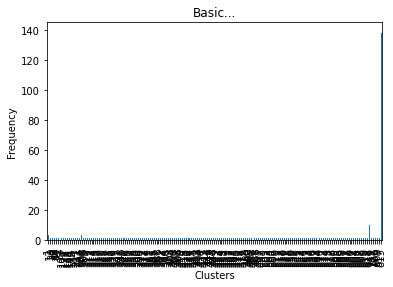

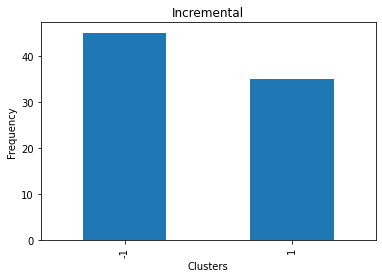

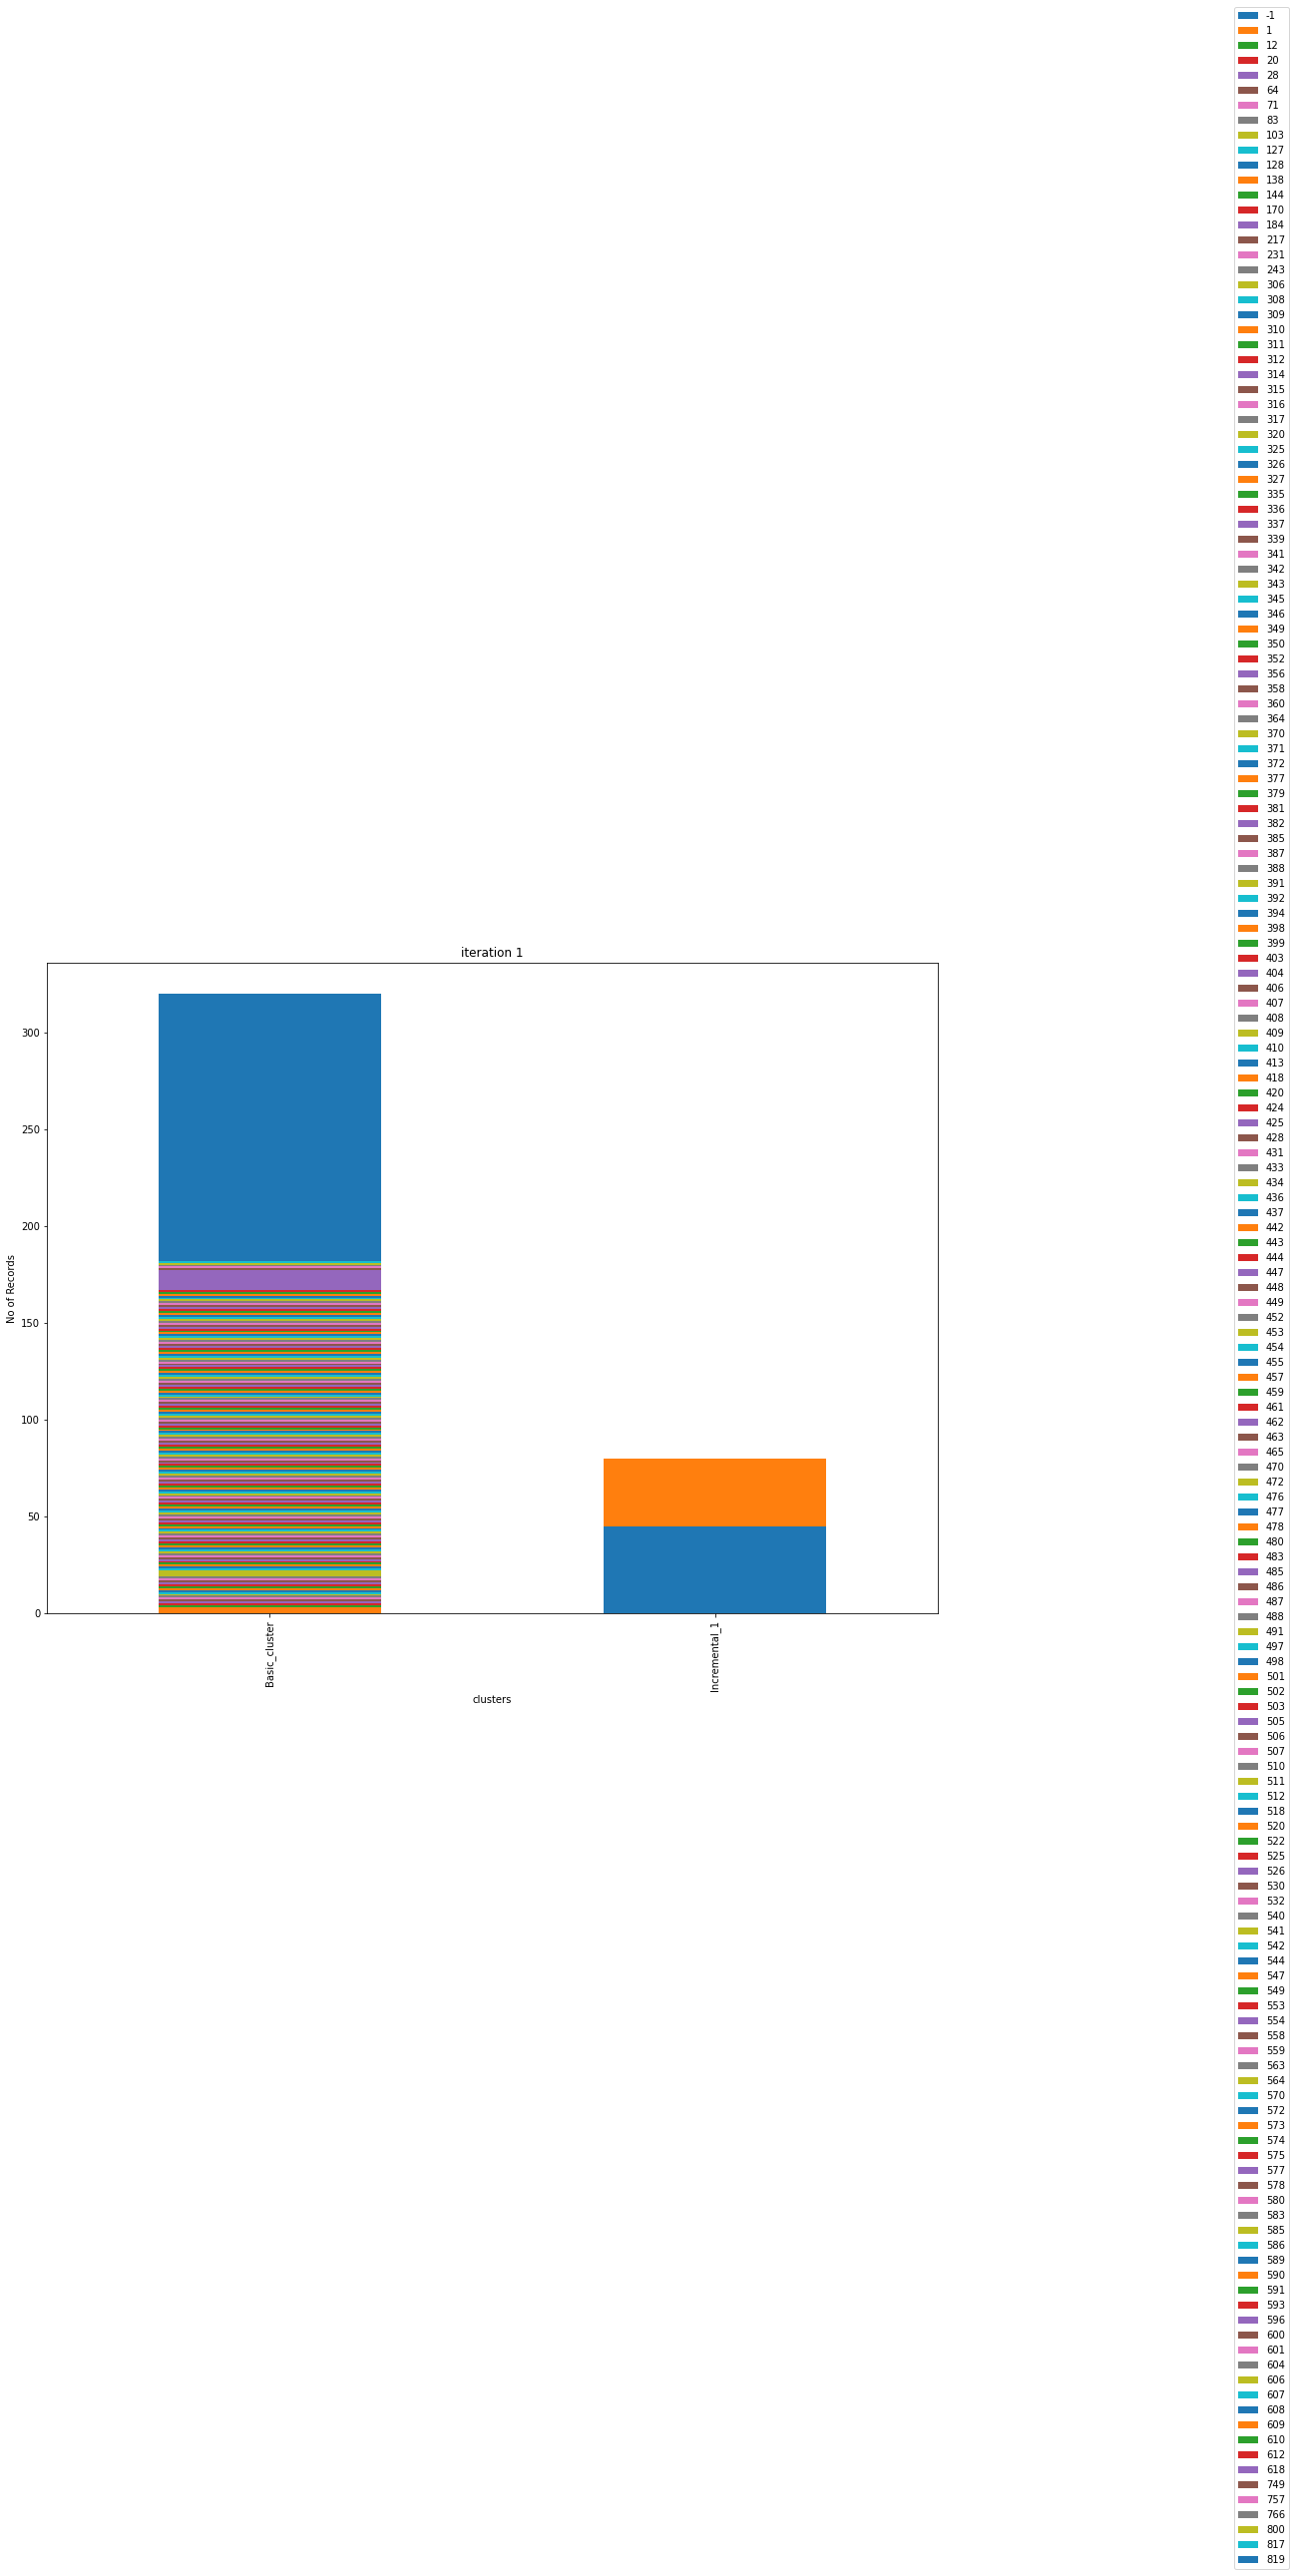

Execution time 30.765785217285156 seconds


In [ ]:
#main function
def main():
  start = time.time()
  #add csv name
  df = pd.read_csv('/content/meter_dataset.csv')
  print(df.head())
  train,test,df1,df2 = scale(df)
  df_basic,df_train = basic_cluster_lone(train,df1)
  df_incremental , dftest = incremental_cluster(test,df2)
  merge_basic_incremental1 = mergefile_graph(df_basic,df_incremental)
  mergefile_representative(df_train,dftest)
  visualize(df_basic,df_incremental,merge_basic_incremental1)
  print('Execution time {} seconds'.format(time.time()-start))

if __name__=='__main__':
  main()